In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

Understand the deflection angle from a keplerian hyperbolic trajectory

Notes. 

- You can solve for the eccentricity based on the deflection angle, which is cool
- You also find what the minimum impact parameter is. Amazingly, it was the distance at which you would have a bound orbit! 
- Also, you have to realize that the solution for the position as a function of the true anomonly, gives negative solutions for e>1. at least given the typical expression for the radius as a function of distance. This was making it hard to interprete the trajectory in the polar plane. So for me, it's better to write the trajectory as: 
$$ r\left(\psi\right) = \frac{a(e-1)}{1+e\cos\left(\psi\right)}$$


- also, to get the solution of the change in momentum of the particle that is flying by, you still can use the impulse approximation, or the argument that the magnitude of the exchanged momentm is $\vec{F} \Delta t \approx \frac{Gm}{b^2}\frac{2b}{v}$. So you know this is how much momentum the stationary particle is picking up, and this it's initial momentum is zero. However, you have to realize that $p_f \cdot P_o \neq 0$, where $p_f$ is the final momentum of the stationary one and $P_o$ is the initial velocity of the impactor... Instead, you realize that $p_f$ is along the line of symmetry for the hyperbola.This allows you to continue without solving for the integral. 

In [2]:
def r(true_anomaly, a, e, psi0):
    """Calculate the radius at a given true anomaly for a hyperbolic orbit."""
    return a * (e - 1) / (1 - e * np.cos(true_anomaly+psi0))

In [3]:
def mean_anomaly(true_anomaly, e):
    """Calculate the mean anomaly from the true anomaly for a hyperbolic orbit."""
    return np.arccosh((1 + e * np.cos(true_anomaly)) / (e * np.cos(true_anomaly)))

In [4]:
# I solved for the eccentricity based no the deflection angle 
deflectionangle = np.pi/3
a = 1 
e = 1/np.cos((np.pi-deflectionangle)/2)
print(e)
psi0=0
print(np.acos(-1/e)*180/np.pi)  # This is the angle at which the orbit crosses the x-axis

2.0000000000000004
119.99999999999999


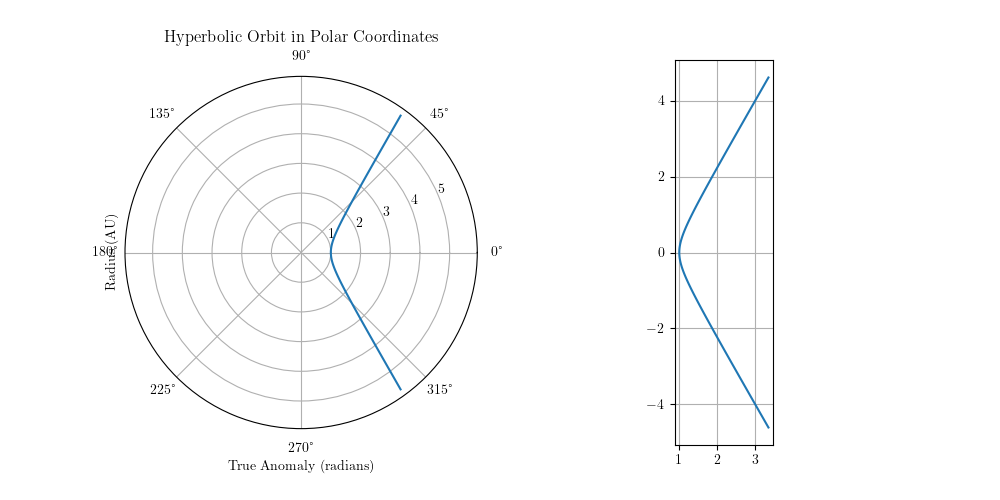

In [5]:
true_anomalies = np.linspace(-0.9*np.acos(1/e),0.9*np.acos(1/e) ,100)
myr = -r(true_anomalies, a, e,psi0)
# make the xy array
theta = mean_anomaly(true_anomalies, e)
xy = np.array([myr * np.cos(true_anomalies), myr * np.sin(true_anomalies)]).T
cond = myr>0
fig = plt.figure(figsize=(10, 5))
ax1= fig.add_subplot(121, projection='polar')
ax2 = fig.add_subplot(122)
# make the first plot in polar coordinates
ax1.plot(true_anomalies[cond],myr[cond], label='Hyperbolic Orbit )')
ax1.set_title('Hyperbolic Orbit in Polar Coordinates')
ax1.set_xlabel('True Anomaly (radians)')
ax1.set_ylabel('Radius (AU)')
ax2.plot(xy[cond, 0], xy[cond, 1], )
ax2.set_aspect('equal')
plt.grid(True)

# two body relaxation time as a random walk ?

In [6]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
import twoBodyRelaxation as TBR

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

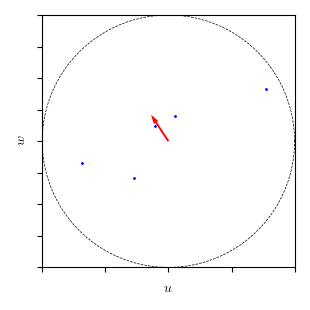

In [7]:
NP = 10000
norbits = 1 
dtfactor = 1/500
dt,nsteps = TBR.set_integration_parameters(norbits=norbits, dtfactor=dtfactor)
x0,v0= np.array([-1, 0, 0]), np.array([1, 0, 0])
speed=np.linalg.norm(v0)  # speed is the norm of the initial velocity
# set the overal density of the disk
numberDensity = NP / np.pi  # number of particles in the "cylinder" (N / (pi R^2 * v * T)) T = R/v
Ndisk = np.random.poisson(numberDensity*speed*dt) # number of particles in the section of the disk
b_mag, theta = TBR.generate_uniform_disk(Ndisk) 
u, w = b_mag * np.cos(theta), b_mag * np.sin(theta) 
bmin = 2 / (NP * speed**2)
thetas = np.linspace(0, 2*np.pi, 100)
impulse = TBR.change_in_velocity_from_all_particles_in_the_disk(NP, speed, u, w, cutBmin=True)
norm_impulse = np.linalg.norm(impulse)


fig= plt.figure(figsize=((6.3-0.1)/2,(6.3-0.1)/2))
ax = fig.add_subplot(111, )
ax.scatter(u, w, s=1, c='blue', alpha=1)
ax.quiver(0,0, impulse[1]/norm_impulse, impulse[2]/norm_impulse, scale=8, color='red', alpha=1, lw=10, label='Net Impulse')
ok=10
ax.plot(np.cos(thetas), np.sin(thetas), c='black', lw=0.5, ls='--', label='Extent of system')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
# ax.legend(loc='lower left', bbox_to_anchor=(0, 1))
ax.set_aspect('equal')
ax.set_xlabel(r'$u$')
ax.set_ylabel(r'$w$')
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.tight_layout()

Let's say that I'm traveling in a uniformly dense medium of star particles and traveling at a speed of $v$ and everything else in the medium is stationary and all stars have the same mass. I want to know how the stars in the medium eventually cause the trajectory of the target star to deviate significantly. To compute this, we will use the impulse approximation, which means that the stars in the medium will not gain any momentum, and that we can assume we only have an addidtive contribution perpendicular to the particles initial trajectory, and that the component parallel to the initial motion is unchanged. The perpendicular component from each interaction is thus: 


$$ \Delta v_\perp = \int F dt \approx F_\perp \Delta t \approx \frac{Gm}{b^2}\frac{2b}{v} \approx \frac{Gm}{bv} $$

Now, if we place outselves in a uniformly density medium: $n=\frac{3N}{4\pi R^3}$, we can compute the change in velocity from each particle on our star. We can do this by summing over all particles that are within a volume infintessimal in a disk perpendicular to the motion of the particle. If the star is originally traveling along the x-axis, then, for a set of discrete particles, the change in velocity is a vector and is thus:

$$ \Delta \vec{v} =  \sum_i^{C}  \frac{2 GM}{b_iv} \begin{bmatrix} 0\\\cos(\theta_i) \\ \sin(\theta_i) \end{bmatrix} $$

where $C$ is the number of stars within the volume element under consideration, which is a thick ring of size: $dr\left(rd\theta\right)vdt$

Numerically, I just update the positions and velocities using a simple newton's method: 

$$ 
\begin{align}
\vec{v}_{j+1} &= \vec{v}_{j} + \Delta \vec{v} \Delta t\\
\vec{x}_{j+1} &= \vec{x}_{j} + \vec{v}_{j+1} \Delta t  
\end{align}
$$

I do this numerically in two steps. First, I generate a number of particles within a disk that is perpendicular to the instantaneous velocity vector. The volume of my disk element is $\pi R^2 v \Delta t$, where $R$ is the size of my system and $\Delta t$ is the time step. The product of $\pi R^2 v \Delta t$ and the number density $n$, gives me the $\langle C\rangle$, which is about the number of particles I should have in the disk. I sample $C_j$ from a poisson distribution whose rate parameter is $\langle C\rangle$. Then, I generate $C_j$ particles in a disk. The positions of particles in a disk properly, which is randomly uniformly distributed in $\theta$ and $r^2$. I perform this sampling in a different coordinate system: $u,w$ where $u_i ,v_i=r_i\left[\cos(\theta_i),\sin(\theta_i)\right]$. Then, I can deproject this back into 3D space by creating two arbitrary axes: $\hat{e}_1,\hat{e}_2$, where $\hat{e}_0$ is $\vec{v}/|\vec{v}|$ to form an orthonormal basis. I repeat this process to simulate the random walk with gravitational scattering. Until this point, what do you think? 


ok. one thing. Why do you suggest 

$ \langle \delta v^2\rangle(t) = | \vec{v}(t) - \vec{v}_0|^2 $? 

Becuase, when trying to measure that growth, I was doing the finite differences: 

$ \langle \delta v^2\rangle(t_{j+1}) = | \vec{v}(t_{j+1}) - \vec{v}(t_{j})|^2 $

And then I was finding the cummulative sum. and then I was tracking this cummulative sum as a function of time. Is that what I should be doing? I was thinking that this cummulative sum should reach $v^2$ when $t=\tau_\mathrm{relax}$



I start with a single interaction: 

$$ \delta \vec{v}_i =  \sum_i^{C}  \frac{2 GM}{b_iv} \begin{bmatrix} 0\\\cos(\theta_i) \\ \sin(\theta_i) \end{bmatrix} $$

And in the end, we want to find the $\langle \delta v_i^2\rangle$, right? well first, I like to recognize that:  $\langle \delta \vec{v}_i \rangle$ is zero. To do this, for me, you have to state that the uniform is, on average, uniformly distributed. Because if you do that, instead of a sum over $\theta_i$, you can integrate over $d\theta$. And, we only need to do this for a single ring to note that: 

$$ \Delta \vec{v}(b) = \sum \delta \vec{v}_i = \sum_i^{C}\frac{2 GM}{bv}\begin{bmatrix} 0\\\cos(\theta_i) \\ \sin(\theta_i) \end{bmatrix} = \frac{2 GM}{bv} \int_{0}^{2\pi} \begin{bmatrix} 0\\\cos(\theta) \\ \sin(\theta) \end{bmatrix} d\theta  = \begin{bmatrix} 0\\ 0 \\ 0 \end{bmatrix}  $$


Therefore: $\langle \Delta \vec{v} \rangle =0$.  And this is a classic characterisitic of a random walk, so no surprise here. Ok, so moving on to $\langle \delta v^2\rangle$. How should we do this? I have two plans of attack in mind. When I follow the books, I have the feeling that were finding the average $\delta v^2$ per time step, but however it's the total $\delta v^2$ per disk, and not the average over the disk. Now. if I want to find the average per disk, I can do this: 

$$ \langle \delta v^2 \rangle = \frac{1}{\pi R^2} \int \delta v^2 rdrd\theta$$ 

Even in the case of discrete particles: 

$$ \delta v^2_i(b_i) = \sum_i \left(\frac{2Gm}{b_iv}\right)^2 \begin{bmatrix} 0&\cos(\theta_i) & \sin(\theta_i) \end{bmatrix} \begin{bmatrix} 0\\\cos(\theta_i) \\ \sin(\theta_i) \end{bmatrix}$$

Actually, I want to stop here. Is this the right way to find $\langle \delta v^2 \rangle$ ? do you start by finding $\delta v^2$ for each individual particle first, and then sum over all the particles? Or do you sum over them first and then square them? because it's not the same thing. 

so, if were in a uniform sphere, then the result is: 

$\frac{d\langle \delta v^2\rangle}{dt} = 6 \frac{v^2}{t_\mathrm{dyn}}$

In [8]:
ncpu = mp.cpu_count() - 2
trials = ncpu
NP = int(5e2)
tdyn = 1
trelax_book =  tdyn * NP /np.log(NP) / 10 
trelax_me = (1/8) * tdyn * NP / np.log(NP/2)
print(trelax_book)
print(trelax_me)
norbits = 2*trelax_me
dtfactor = 1 / 100
x0 = np.array([-1, 0, 0])
v0 = np.array([1, 0, 0])
dt, nsteps = TBR.set_integration_parameters(norbits=norbits, dtfactor=dtfactor)
# Prepare arguments for each trial
args_list = [(NP, norbits, dtfactor, x0, v0, dt) for _ in range(trials)]

with mp.Pool(ncpu) as pool:
    results = pool.map(TBR.run_trial_experiment_always_in_the_center, args_list)

# Unpack results
xs, vs, us, ws, xdps, ydps, zdps = zip(*results)
tsteps = np.arange(nsteps) * dt

8.045559624700124
11.319467968669104
expectation in disk:  1.5915494309189535
expectation in disk:  1.5915494309189535
expectation in disk:  1.5915494309189535
expectation in disk:  1.5915494309189535
expectation in disk:  1.5915494309189535
expectation in disk:  1.5915494309189535


In [9]:
deltaVGPT = []
for i in range(trials):
    v= vs[i]
    delta_v = v[1:] - v[:-1]
    delta_v_squared = np.sum(delta_v**2, axis=1)
    cumulative_dv2 = np.cumsum(delta_v_squared)
    deltaVGPT.append(cumulative_dv2)


In [10]:
# Calculate the cumulative squared velocity differences
deltaV2s = []
for i in range(trials):
    v = vs[i]
    dv = np.diff(v, axis=0)
    dv2 = np.sum(dv**2, axis=1)  # shape: (Nstep,)
    deltaV2 = np.cumsum(dv2) 
    deltaV2s.append(deltaV2)
timesteps = np.arange(nsteps) * dt  # shape: (Nstep+1,)

In [11]:
# rms sum 
deltaV2RMS = []
for i in range(trials):
    v = vs[i]
    dv = np.diff(v, axis=0)
    dv2 = np.sqrt(np.sum(dv**2, axis=1))  # shape: (Nstep,)
    deltaV2 = np.cumsum(dv2) 
    deltaV2RMS.append(deltaV2)

In [12]:
deltaV20=[]
for i in range(trials):
    v = vs[i]
    dv = v - v[0]
    dv2 = np.sum(dv**2, axis=1)  # shape: (Nstep,)
    deltaV2 = np.cumsum(dv2) 
    deltaV20.append(deltaV2[1:])

In [13]:
# what should a typical delta v be? 
expected_dV=12*dt*np.log(NP/2)/NP
expected_dV*nsteps

np.float64(2.998815853709343)

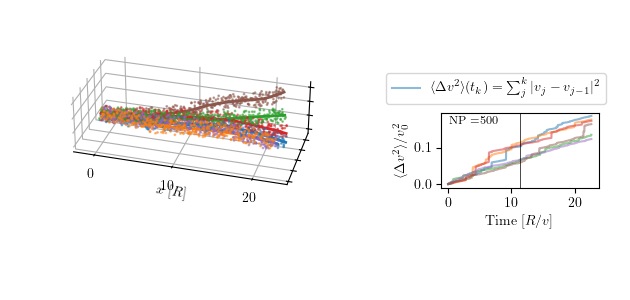

In [14]:
fig= plt.figure(figsize=(8.3-2, 3))
axis=[]
# gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.2)
# axis.append(fig.add_subplot(gs[0], projection='3d'))
# axis.append(fig.add_subplot(gs[1]))
axis.append(fig.add_axes([0.00, 0.20, 0.6, 0.8], projection='3d')) # [left, bottom, width, height])
axis.append(fig.add_axes([0.70, 0.375, 0.25, 0.25]))
NSKIP=10
for i in range(0,trials):
    line,=axis[0].plot(xs[i][:, 0], xs[i][:, 1], xs[i][:,2], lw=2, alpha=1)
    axis[0].scatter(xdps[i][::NSKIP], ydps[i][::NSKIP], zdps[i][::NSKIP], s=1, alpha=0.5,color=line.get_color())
    if i == 0:
        label0=r"$\langle\Delta v^2\rangle (t_k)=\sum_j^{k} |v_j - v_{j-1}|^2$"
        label1=r"$|v_j - v_0|^2$"
        label2=r"$\sum_j \left(\sqrt{|v_j - v_{j-1}|^2}\right)$"
    else:
        label0=None
        label1=None
        label2=None
    axis[1].plot(tsteps, deltaV2s[i], alpha=0.5, ls="-", color=line.get_color(), label=label0)

# axis[0].set_title(r'$\mathrm{Gravitational~random~walk}$')
axis[0].set_xlabel(r'$x~[R]$',labelpad=0)
# axis[0].set_xticklabels([0,10,20,30])
# axis[0].set_ylabel(r'$y~[R]$')
# axis[0].set_zlabel(r'$z~[R]$')
# axis[1].hlines(1, 0, tsteps[-1], color='k', linestyle='--', lw=.5, )
axis[1].text(0.05,0.95,r"$\mathrm{{NP}}=${}".format(NP), transform=axis[1].transAxes, ha='left', va='top', fontsize="small")
axis[1].set_ylabel(r"$\langle\Delta v^2\rangle / v_0^2$")
axis[1].set_xlabel(r'$\mathrm{Time~}[R/v]$')
# axis[1].set_xlim(0, tsteps[-1])
axis[1].legend(loc='lower center', bbox_to_anchor=(0.35, 1.02), ) # x=center, y=just above the axes
ylims=axis[1].get_ylim()
axis[1].vlines(trelax_me, ylims[0], ylims[1], color='k', linestyle='-', lw=.5)
axis[1].set_ylim(ylims)

# axis[1].set_ylim(0, 2)
axis[0].set_aspect('equal')
axis[0].xaxis.pane.set_visible(False)
axis[0].yaxis.pane.set_visible(False)
axis[0].zaxis.pane.set_visible(False)
axis[0].grid(True)
axis[0].view_init(elev=30, azim=-74)
axis[0].set_yticklabels([])
axis[0].set_zticklabels([])
# axis[0].set_xlim(-1, 1)

fig.savefig('../../images/twoBodyRelaxation.png', dpi=300, bbox_inches='tight')

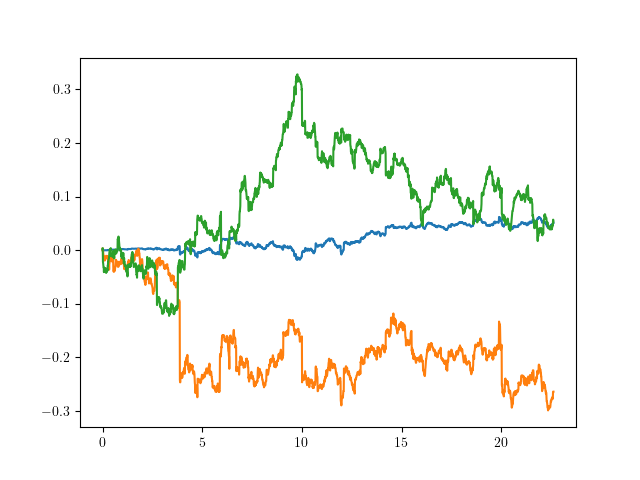

In [15]:
fig,axis=plt.subplots(1,1)
v = vs[1]
axis.plot(timesteps,v[1:,0]-1)
axis.plot(timesteps,v[1:,1])
axis.plot(timesteps,v[1:,2])


In [16]:
# for how many clusters are we bad for? 
import tstrippy

In [17]:
GCdata=tstrippy.Parsers.baumgardtMWGCs().data

In [18]:
from astropy import units as u
unitT=u.Unit(tstrippy.Parsers.unitbasis['time'])
Mass=GCdata['Mass'].value
rhm=GCdata['rh_m'].value
m_star= 0.8
N = Mass / m_star
G=tstrippy.Parsers.G
tcross = np.sqrt(rhm**3 / (G * Mass)) *unitT
trelax = (1/8) * tcross * N / np.log(N/2)
cond=trelax > 5*u.Gyr
print(GCdata['Cluster'][cond])
targetIndex = np.where(GCdata['Cluster']=="NGC5139")[0][0]

trelax[targetIndex]

['NGC2419' 'NGC5139' 'Pal14' 'Pal15' 'FSR1758' 'Ter8' 'SagittariusII']


<Quantity 10.80884026 kpc s / km>

In [22]:
print(np.max(trelax.to(u.Myr)))
print(np.mean(trelax.to(u.Myr)))
print(np.median(trelax.to(u.Myr)))
print(np.min(trelax.to(u.Myr)))

21307.45219578029 Myr
1506.8347657837721 Myr
805.598688021329 Myr
39.85095384776519 Myr


In [23]:
import twobodyCoPilotSolution as TBCP

Starting two-body relaxation experiment...
Initial conditions: v0=1, n=3183.098861837907, M=1, R=1
Theoretical relaxation time: 0.00
Relaxation achieved at t = 0.01
Final speed: 13.265 (initial: 1.000)

Experiment completed!
Total simulation time: 0.0 seconds
Total encounters: 110


In [33]:
np.random.random(10).shape

(10,)

In [30]:
TBCP.run_single_timestep([1,0,0], .01, 10, R, M, G)

(array([-0.4577264 ,  1.24440812,  0.19166423]), 1)